<a href="https://colab.research.google.com/github/farrelrassya/python-natural-language-Processing-cookbook/blob/main/chapter%2009%20-%20NLU%20%20/%20Chapter_09_NLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 9 — Natural Language Understanding

**Natural Language Understanding (NLU)** goes beyond classification and generation: it aims to *interpret* text -- answering questions, detecting logical relationships between sentences, summarizing documents, and explaining model decisions.

This chapter covers eight recipes spanning four NLU capabilities:

| Capability | Recipes | Models Used |
|---|---|---|
| **Question Answering** | 1 (short text), 2 (long text), 3 (extractive corpus QA), 4 (abstractive corpus QA) | BERT-QA, Flan-T5, BM25 retrieval |
| **Summarization** | 5 | T5-large, BART-CNN, PEGASUS |
| **Textual Entailment** | 6 | T5 (MNLI task prefix) |
| **Explainability** | 7 (LIME), 8 (Anchor) | Classifier-agnostic perturbation methods |

The progression moves from extracting exact answer spans from context, to generating abstractive answers and summaries, to understanding *why* a classifier makes its decisions.

## 0 — Environment Setup

In [1]:

# 0.1  Install packages

import os
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["TOKENIZERS_PARALLELISM"]       = "false"

!pip install -q \
    datasets \
    evaluate \
    transformers \
    accelerate \
    sentencepiece \
    protobuf \
    torch \
    lime \
    anchor-exp \
    spacy

!python -m spacy download en_core_web_sm -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 32.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:

# 0.2  Core imports & configuration

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Patch jupyter_client to silence datetime.utcnow() spam
from datetime import datetime, timezone
try:
    import jupyter_client.session as _jcs
    _jcs.utcnow = lambda: datetime.now(timezone.utc)
except Exception:
    pass

import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Compute device: {device}")
if device.type == "cuda":
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
else:
    print("  (Models will run on CPU — inference will be slower)")

print("Setup complete.")


Compute device: cuda
  GPU: Tesla T4
Setup complete.


---

## Recipe 1 — Answering Questions from a Short Text Passage

**Extractive question answering** locates the answer as a span within a given context passage. The model does not generate new text -- it highlights the substring that best answers the question.

The architecture is BERT fine-tuned on SQuAD (Stanford Question Answering Dataset). For each token position $i$, the model predicts two scores:

$$s_{\text{start}}(i) = \mathbf{w}_s^T \mathbf{h}_i, \qquad s_{\text{end}}(i) = \mathbf{w}_e^T \mathbf{h}_i$$

where $\mathbf{h}_i \in \mathbb{R}^{1024}$ is the token's contextual representation. The answer span is the substring from $\arg\max_i s_{\text{start}}(i)$ to $\arg\max_j s_{\text{end}}(j)$ that maximizes $s_{\text{start}}(i) + s_{\text{end}}(j)$ with $j \ge i$.

In [3]:

# 1.1  Initialize QA pipeline with BERT

from transformers import pipeline, BertForQuestionAnswering, BertTokenizer

qa_model = BertForQuestionAnswering.from_pretrained(
    "bert-large-uncased-whole-word-masking-finetuned-squad")
qa_tokenizer = BertTokenizer.from_pretrained(
    "bert-large-uncased-whole-word-masking-finetuned-squad")

qa_pipeline = pipeline("question-answering",
                       model=qa_model,
                       tokenizer=qa_tokenizer,
                       device=device)

print("QA pipeline ready (BERT-large, SQuAD fine-tuned)")


BertForQuestionAnswering LOAD REPORT from: bert-large-uncased-whole-word-masking-finetuned-squad
Key                      | Status     |  | 
-------------------------+------------+--+-
bert.pooler.dense.weight | UNEXPECTED |  | 
bert.pooler.dense.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


QA pipeline ready (BERT-large, SQuAD fine-tuned)


We load `bert-large-uncased-whole-word-masking-finetuned-squad`, a $335$M-parameter model. **Whole-word masking** means that during pre-training, entire words (not just subword tokens) were masked -- this produces better contextual representations for QA because the model learns to reconstruct complete words from surrounding context.

In [4]:

# 1.2  Answer questions from a context passage

context = (
    "The cat had no business entering the neighbors garage, but she was "
    "there to help. The neighbor, who asked not to be identified, said "
    "she didn't know what to make of the cat's behavior. She said it "
    "seemed like it was trying to get into her home, and that she was "
    "afraid for her life. The neighbor said that when she went to check "
    "on her cat, it ran into the neighbor's garage and hit her in the "
    "face, knocking her to the ground."
)

questions = [
    "Where was the cat trying to enter?",
    "What did the cat do after entering the garage?",
    "How did the neighbor feel?",
]

print(f"Context ({len(context)} chars):")
print(f'  "{context[:100]}..."')
print()

for q in questions:
    result = qa_pipeline(question=q, context=context)
    print(f"Q: {q}")
    print(f'A: "{result['answer']}"  (score: {result["score"]:.3f}, '
          f'span: [{result["start"]}:{result["end"]}])')
    print()


Context (427 chars):
  "The cat had no business entering the neighbors garage, but she was there to help. The neighbor, who ..."

Q: Where was the cat trying to enter?
A: "the neighbors garage"  (score: 0.256, span: [33:53])

Q: What did the cat do after entering the garage?
A: "hit her in the face, knocking her to the ground"  (score: 0.380, span: [379:426])

Q: How did the neighbor feel?
A: "afraid for her life"  (score: 0.373, span: [262:281])



The model extracts answer spans directly from the context. The **score** is the product of the start and end logit softmax probabilities -- higher means more confident. Notice the model handles different question types: location ("Where"), action ("What did"), and emotion ("How did").

The `start` and `end` indices point to exact character positions in the context, which is useful for highlighting answers in a UI.

**Limitation:** The model can only answer questions whose answers appear verbatim in the context. If the answer requires reasoning or synthesis, extractive QA fails -- that is where abstractive approaches (Recipe 4) come in.

---

## Recipe 2 — Answering Questions from a Long Text Passage

For longer texts that exceed a model's maximum input length ($512$ tokens for BERT), we need to **chunk** the text into overlapping windows and run QA on each chunk, then select the highest-confidence answer across all chunks.

The book uses DeepPavlov's KBQA system for open-domain QA backed by knowledge graphs. Here we demonstrate the same concept using the Hugging Face QA pipeline with automatic stride-based chunking, which handles long documents seamlessly.

In [5]:

# 2.1  Long-context QA with stride

# Long passage (multiple paragraphs)
long_context = (
    "The Great Pyramid of Giza is the oldest and largest of the pyramids in "
    "the Giza pyramid complex bordering present-day Giza in Greater Cairo, "
    "Egypt. It is the oldest of the Seven Wonders of the Ancient World, and "
    "the only one to remain largely intact. It was built as a tomb for the "
    "Fourth Dynasty Egyptian pharaoh Khufu and was completed around 2560 BC. "
    "The Great Pyramid was the tallest man-made structure in the world for "
    "more than 3,800 years. Originally, the Great Pyramid was covered by "
    "limestone casing stones that formed a smooth outer surface. What is seen "
    "today is the underlying core structure. The original height was 146.5 "
    "metres (481 ft), but today it stands at 138.8 metres (455 ft). "
    "The pyramid is estimated to have around 2,300,000 stone blocks that "
    "weigh from 2.5 to 15 tonnes each. The total mass of the pyramid is "
    "estimated at 6.1 million tonnes. The base covers an area of about "
    "53,000 square metres (570,000 sq ft)."
)

print(f"Long context: {len(long_context)} chars, "
      f"~{len(long_context.split())} words")

long_questions = [
    "When was the Great Pyramid completed?",
    "How tall was the pyramid originally?",
    "How many stone blocks does the pyramid have?",
    "Who was the pyramid built for?",
]

for q in long_questions:
    result = qa_pipeline(question=q, context=long_context)
    print(f"Q: {q}")
    print(f'A: "{result["answer"]}"  (score: {result["score"]:.3f})')
    print()


Long context: 936 chars, ~165 words
Q: When was the Great Pyramid completed?
A: "2560 BC"  (score: 0.679)

Q: How tall was the pyramid originally?
A: "146.5 metres (481 ft)"  (score: 0.580)

Q: How many stone blocks does the pyramid have?
A: "2,300,000"  (score: 0.761)

Q: Who was the pyramid built for?
A: "pharaoh Khufu"  (score: 0.751)



The QA pipeline handles multi-paragraph input by internally splitting the context into overlapping windows (controlled by the `doc_stride` parameter, default 128 tokens). Each window is scored independently, and the answer with the highest confidence across all windows is returned.

**Open-Domain QA** (as implemented by systems like DeepPavlov KBQA) goes further: it searches a knowledge base (e.g., Wikipedia/Wikidata) to find relevant passages, then applies extractive or abstractive QA. The key difference is that the user does not provide the context -- the system retrieves it.

For production open-domain QA, the **retriever-reader** pattern (Recipe 3) is the standard architecture.

---

## Recipe 3 — Extractive QA from a Document Corpus

When you have hundreds or thousands of documents, scanning all of them for every question is prohibitively slow. The solution is a **two-stage pipeline:**

$$\underbrace{\text{Query}}_{\text{user question}} \;\xrightarrow{\text{Retriever}}\; \underbrace{\text{Top-}k \text{ documents}}_{\text{candidate passages}} \;\xrightarrow{\text{Reader}}\; \underbrace{\text{Answer span}}_{\text{exact answer}}$$

**Stage 1 — Retriever (BM25):** Uses the classic BM25 scoring function to find the top-$k$ most relevant documents. BM25 scores each document $d$ for query $q$ as:

$$\text{BM25}(d, q) = \sum_{t \in q} \text{IDF}(t) \cdot \frac{f(t, d) \cdot (k_1 + 1)}{f(t, d) + k_1 \cdot \left(1 - b + b \cdot \frac{|d|}{\text{avgdl}}\right)}$$

**Stage 2 — Reader (BERT-SQuAD):** Runs extractive QA on the retrieved passages to find the exact answer span.

The book uses the Haystack framework for this. Here we implement the same retriever-reader concept using lightweight components compatible with Colab.

In [6]:

# 3.1  Build a simple document corpus

documents = [
    {"title": "Great Pyramid of Giza",
     "content": "The Great Pyramid of Giza was built around 2560 BC for "
     "the pharaoh Khufu. It is the oldest of the Seven Wonders of the "
     "Ancient World and the only one still largely intact. The pyramid "
     "originally stood 146.5 metres tall with smooth limestone casing "
     "stones. It contains approximately 2.3 million stone blocks."},
    {"title": "Hanging Gardens of Babylon",
     "content": "The Hanging Gardens of Babylon were described as a "
     "remarkable feat of engineering with an ascending series of tiered "
     "gardens containing a wide variety of trees, shrubs, and vines. "
     "They were said to have been built in the ancient city of Babylon, "
     "near present-day Hillah, Iraq. Their existence has not been "
     "definitively proven by archaeology."},
    {"title": "Colossus of Rhodes",
     "content": "The Colossus of Rhodes was a statue of the Greek sun "
     "god Helios, erected in the city of Rhodes by Chares of Lindos "
     "in 280 BC. It stood approximately 33 metres (108 feet) high, "
     "making it one of the tallest statues of the ancient world. The "
     "statue was destroyed by an earthquake in 226 BC, having stood "
     "for only 54 years."},
    {"title": "Lighthouse of Alexandria",
     "content": "The Lighthouse of Alexandria, also known as the Pharos "
     "of Alexandria, was built between 280 and 247 BC on the island of "
     "Pharos in Alexandria, Egypt. Estimates of its height range from "
     "100 to 140 metres. It was one of the tallest man-made structures "
     "for many centuries and was damaged by several earthquakes before "
     "being abandoned in 1480."},
    {"title": "Temple of Artemis",
     "content": "The Temple of Artemis was a Greek temple dedicated to "
     "the goddess Artemis. Located in Ephesus near the modern town of "
     "Selcuk in Turkey, it was completely rebuilt three times before "
     "its final destruction in 401 AD. The temple was 137 metres long "
     "and was famous for its elaborate decorations."},
    {"title": "Statue of Zeus at Olympia",
     "content": "The Statue of Zeus at Olympia was a giant seated figure "
     "made by the Greek sculptor Phidias around 435 BC. The statue was "
     "about 12 metres (40 feet) tall and was made of ivory plates and "
     "gold panels on a wooden framework. It was placed in the Temple "
     "of Zeus at Olympia, Greece."},
    {"title": "Mausoleum at Halicarnassus",
     "content": "The Mausoleum at Halicarnassus was a tomb built between "
     "353 and 350 BC for Mausolus, a satrap of the Achaemenid Empire. "
     "The structure was approximately 45 metres (148 feet) in height. "
     "The word mausoleum has since come to be used generically for any "
     "grand tomb. It was located in present-day Bodrum, Turkey."},
]

print(f"Corpus: {len(documents)} documents")
for doc in documents:
    print(f'  [{doc["title"]}] {len(doc["content"])} chars')


Corpus: 7 documents
  [Great Pyramid of Giza] 307 chars
  [Hanging Gardens of Babylon] 341 chars
  [Colossus of Rhodes] 319 chars
  [Lighthouse of Alexandria] 338 chars
  [Temple of Artemis] 290 chars
  [Statue of Zeus at Olympia] 275 chars
  [Mausoleum at Halicarnassus] 306 chars


We work with a compact corpus of $7$ documents about the Seven Wonders of the Ancient World, with document lengths ranging from $275$ to $341$ characters. This small corpus is ideal for demonstrating the retriever-reader pattern: large enough to require retrieval (scanning all 7 documents per query would be wasteful at scale), but small enough that we can inspect every retrieval decision. In production systems, this same architecture handles millions of documents using Elasticsearch or FAISS-backed document stores.

In [7]:

# 3.2  BM25 retriever (lightweight implementation)

import math
from collections import Counter

class SimpleBM25:
    def __init__(self, documents, k1=1.5, b=0.75):
        self.docs = documents
        self.k1, self.b = k1, b
        self.tokenized = [d["content"].lower().split() for d in documents]
        self.avgdl = np.mean([len(d) for d in self.tokenized])
        self.N = len(documents)
        self.df = Counter()
        for doc_tokens in self.tokenized:
            for t in set(doc_tokens):
                self.df[t] += 1

    def score(self, query):
        query_tokens = query.lower().split()
        scores = []
        for i, doc_tokens in enumerate(self.tokenized):
            tf = Counter(doc_tokens)
            s = 0.0
            for t in query_tokens:
                if t not in tf:
                    continue
                idf = math.log((self.N - self.df[t] + 0.5) /
                               (self.df[t] + 0.5) + 1)
                freq = tf[t]
                denom = freq + self.k1 * (1 - self.b + self.b *
                        len(doc_tokens) / self.avgdl)
                s += idf * (freq * (self.k1 + 1)) / denom
            scores.append(s)
        return scores

    def retrieve(self, query, top_k=3):
        scores = self.score(query)
        ranked = sorted(enumerate(scores), key=lambda x: -x[1])
        return [(self.docs[i], s) for i, s in ranked[:top_k]]

retriever = SimpleBM25(documents)

# Test retrieval
query = "Who built the Colossus?"
retrieved = retriever.retrieve(query, top_k=3)
print(f'Query: "{query}"')
print(f"Top {len(retrieved)} retrieved documents:")
for doc, score in retrieved:
    print(f'  [{doc["title"]}] BM25={score:.2f}')


Query: "Who built the Colossus?"
Top 3 retrieved documents:
  [Great Pyramid of Giza] BM25=0.72
  [Mausoleum at Halicarnassus] BM25=0.71
  [Lighthouse of Alexandria] BM25=0.67


The BM25 retriever returned **Great Pyramid** (score $0.72$), **Mausoleum** ($0.71$), and **Lighthouse** ($0.67$) for the query "Who built the Colossus?" The actual Colossus of Rhodes document is **missing** from the top 3.

This is a textbook BM25 failure: the algorithm matches on **exact word overlap**, and the Colossus document uses *"erected"* rather than *"built."* BM25 cannot bridge this synonym gap. The documents that *do* contain "built" (Pyramid: "was built around 2560 BC," Mausoleum: "tomb built between 353 and 350 BC") score higher despite being irrelevant.

This demonstrates why production QA systems increasingly use **dense retrieval** (e.g., DPR) alongside BM25. Dense retrievers encode documents and queries into the same vector space, where "built" and "erected" have similar embeddings. A **hybrid** approach (BM25 + dense) catches both lexical matches and semantic matches.

In [8]:

# 3.3  Extractive QA pipeline (retriever + reader)

def extractive_qa(question, retriever, reader, top_k_retrieve=3,
                  top_k_answers=3):
    candidates = retriever.retrieve(question, top_k=top_k_retrieve)
    all_answers = []
    for doc, bm25_score in candidates:
        result = reader(question=question, context=doc["content"])
        result["source"] = doc["title"]
        result["bm25_score"] = bm25_score
        all_answers.append(result)
    all_answers.sort(key=lambda x: -x["score"])
    return all_answers[:top_k_answers]

test_questions = [
    "Who was the Great Pyramid built for?",
    "How tall was the Colossus of Rhodes?",
    "Where was the Temple of Artemis located?",
    "When was the Lighthouse of Alexandria abandoned?",
    "Who sculpted the Statue of Zeus?",
]

for q in test_questions:
    answers = extractive_qa(q, retriever, qa_pipeline)
    best = answers[0]
    print(f"Q: {q}")
    print(f'A: "{best["answer"]}"  (reader={best["score"]:.3f}, '
          f'source={best["source"]})')
    print()


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Q: Who was the Great Pyramid built for?
A: "Mausolus"  (reader=0.916, source=Mausoleum at Halicarnassus)

Q: How tall was the Colossus of Rhodes?
A: "146.5 metres"  (reader=0.613, source=Great Pyramid of Giza)

Q: Where was the Temple of Artemis located?
A: "Ephesus"  (reader=0.773, source=Temple of Artemis)

Q: When was the Lighthouse of Alexandria abandoned?
A: "1480"  (reader=0.970, source=Lighthouse of Alexandria)

Q: Who sculpted the Statue of Zeus?
A: "Phidias"  (reader=0.994, source=Statue of Zeus at Olympia)



The retriever-reader pipeline reveals both the power and a critical pitfall of two-stage QA:

**Correct answers (3/5):**
- *"Where was the Temple of Artemis?"* $\rightarrow$ **"Ephesus"** (reader $0.773$, from Temple of Artemis) -- correct document retrieved
- *"When was the Lighthouse abandoned?"* $\rightarrow$ **"1480"** (reader $0.970$, from Lighthouse of Alexandria) -- near-perfect confidence
- *"Who sculpted the Statue of Zeus?"* $\rightarrow$ **"Phidias"** (reader $0.994$, from Statue of Zeus at Olympia) -- highest confidence in the batch

**Wrong answers (2/5) -- retriever failures:**
- *"Who was the Great Pyramid built for?"* $\rightarrow$ **"Mausolus"** (reader $0.916$, from Mausoleum at Halicarnassus). The reader confidently answered from the *wrong* document because the retriever never surfaced the Great Pyramid document for this query.
- *"How tall was the Colossus of Rhodes?"* $\rightarrow$ **"146.5 metres"** (reader $0.613$, from Great Pyramid of Giza). Again, the Colossus document was not retrieved (BM25 matched "built" but the Colossus text uses "erected"), so the reader answered from the Pyramid document.

**Critical insight for production systems:** The reader gave a **high-confidence wrong answer** ($0.916$) for the Pyramid question -- it looks authoritative but is completely wrong. This is the most dangerous failure mode in retriever-reader systems: **the reader cannot know it received the wrong document.** In production, combine BM25 with **dense retrieval** (hybrid search) to catch synonym mismatches, and always return the source document alongside the answer so users can verify.

## Recipe 4 — Abstractive QA from a Document Corpus

Extractive QA copies text verbatim from the source. **Abstractive QA** generates a natural-language answer in the model's own words, synthesizing information from retrieved passages. This is the core pattern behind Retrieval-Augmented Generation (RAG):

$$\text{Answer} = \text{LLM}\big(\text{Prompt}(\text{question}, \text{retrieved\_docs})\big)$$

We use Google's **Flan-T5** (instruction-tuned T5) as the generator, combined with our BM25 retriever from Recipe 3.

In [9]:

# 4.1  Initialize Flan-T5 for abstractive generation

from transformers import T5Tokenizer, T5ForConditionalGeneration

flan_tokenizer = T5Tokenizer.from_pretrained(
    "google/flan-t5-base", legacy=False)
flan_model = T5ForConditionalGeneration.from_pretrained(
    "google/flan-t5-base").to(device)

print(f"Flan-T5-base loaded on {device}")
print(f"  Parameters: {sum(p.numel() for p in flan_model.parameters()):,}")


The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Flan-T5-base loaded on cuda
  Parameters: 247,577,856


Flan-T5-base has $247{,}577{,}856$ parameters ($\sim 248$M) -- considerably smaller than the BERT-large QA model ($335$M) yet capable of generating free-form answers rather than just extracting spans. The "Flan" prefix indicates **instruction tuning**: the base T5 model was further trained on $1{,}836$ tasks phrased as natural-language instructions, which is what allows it to follow our RAG prompt without any task-specific fine-tuning.

In [10]:

# 4.2  Build abstractive QA pipeline (RAG pattern)

def abstractive_qa(question, retriever, tokenizer, model,
                   top_k=3, max_answer_length=100):
    candidates = retriever.retrieve(question, top_k=top_k)
    context = " ".join([doc["content"] for doc, _ in candidates])

    prompt = (
        "Answer the following question based on the provided context. "
        "Provide a clear and concise response in your own words, "
        "no longer than 50 words.\n\n"
        f"Context: {context}\n\n"
        f"Question: {question}\n\n"
        "Answer:"
    )

    input_ids = tokenizer(
        prompt, return_tensors="pt", truncation=True,
        max_length=512).input_ids.to(device)

    output_ids = model.generate(
        input_ids, max_new_tokens=max_answer_length,
        num_beams=4, early_stopping=True)

    answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return answer, [doc["title"] for doc, _ in candidates]

rag_questions = [
    "What is the Great Pyramid of Giza?",
    "Where are the Hanging Gardens?",
    "What happened to the Colossus of Rhodes?",
]

for q in rag_questions:
    answer, sources = abstractive_qa(
        q, retriever, flan_tokenizer, flan_model)
    print(f"Q: {q}")
    print(f"A: {answer}")
    print(f"   Sources: {', '.join(sources)}")
    print()


Q: What is the Great Pyramid of Giza?
A: the oldest of the Seven Wonders
   Sources: Great Pyramid of Giza, Colossus of Rhodes, Lighthouse of Alexandria

Q: Where are the Hanging Gardens?
A: near present-day Hilla
   Sources: Hanging Gardens of Babylon, Great Pyramid of Giza, Colossus of Rhodes

Q: What happened to the Colossus of Rhodes?
A: The statue was destroyed by an earthquake in 226
   Sources: Colossus of Rhodes, Temple of Artemis, Lighthouse of Alexandria



The abstractive answers are more readable and natural than the extractive spans from Recipe 3. The model synthesizes information from the retrieved passages rather than copying verbatim. This is the fundamental pattern behind modern RAG systems.

**Extractive vs. Abstractive QA:**

| Aspect | Extractive | Abstractive |
|--------|-----------|-------------|
| **Output** | Exact text span from source | Generated natural language |
| **Faithfulness** | Always grounded in source | May hallucinate |
| **Readability** | Can be fragmentary | Natural and fluent |
| **Attribution** | Easy (exact span + document) | Harder to verify |
| **Use case** | Legal, compliance, fact-checking | Customer support, search |

---

## Recipe 5 — Summarizing Text with Transformer Models

Text summarization condenses a long passage into a shorter version while preserving key information. We compare three models that represent different summarization strategies:

- **T5-large** — General-purpose encoder-decoder, instruction-based
- **BART-CNN** — Denoising autoencoder fine-tuned on CNN/DailyMail news
- **PEGASUS** — Pre-trained with gap-sentence generation, optimized for abstractive summary

In [11]:

# 5.1  Define the passage to summarize

passage = (
    "The color of animals is by no means a matter of chance; it depends "
    "on many considerations, but in the majority of cases tends to "
    "protect the animal from danger by rendering it less conspicuous. "
    "Perhaps it may be said that if coloring is mainly protective, there "
    "ought to be but few brightly colored animals. There are, however, "
    "not a few cases in which vivid colors are themselves protective. "
    "The kingfisher itself, though so brightly colored, is by no means "
    "easy to see. The blue harmonizes with the water, and the bird as "
    "it darts along the stream looks almost like a flash of sunlight."
)

word_count = len(passage.split())
print(f"Original passage: {word_count} words")
print(f'"{passage[:120]}..."')


Original passage: 105 words
"The color of animals is by no means a matter of chance; it depends on many considerations, but in the majority of cases ..."


We use a $105$-word passage about animal coloration as the summarization benchmark. The passage makes a nuanced argument with two key ideas: (1) most animal colors are **protective** camouflage, and (2) even **vivid colors** can be protective (the kingfisher's blue blends with water). A good summary must capture both the general rule and the exception -- dropping either one loses the passage's central insight.

In [12]:
# 5.2 Summarize with T5-large (Native Approach)

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# T5 secara spesifik membutuhkan task prefix untuk tahu apa yang harus dilakukan
input_text = "summarize: " + passage
inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True).to(device)

# Generate summary
summary_ids = t5_model.generate(
    inputs["input_ids"],
    max_length=word_count,
    min_length=20,
    length_penalty=2.0,
    num_beams=4,
    early_stopping=True
)

t5_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("=== T5-large ===")
print(f"Summary ({len(t5_summary.split())} words):")
print(t5_summary)

=== T5-large ===
Summary (47 words):
the color of animals is by no means a matter of chance; it depends on many considerations . in the majority of cases, coloring tends to protect the animal from danger . there are, however, not a few cases in which vivid colors are themselves protective .


**T5-large** produces a **47-word** summary, compressing to **45%** of the original $105$ words. It captures the main argument -- animal coloring is not random but protective -- and preserves the key counterpoint about vivid colors being protective too. However, it drops the concrete kingfisher example and the beautiful sunlight metaphor. The summary reads as a competent paraphrase that prioritizes the abstract argument over illustrative detail.

T5 approaches summarization as a sequence-to-sequence task: the encoder processes the full passage, and the decoder generates the summary token by token, conditioned on the encoded representation. The `max_length` parameter prevents the summary from exceeding the original length (a useful safety guardrail).

In [13]:
# 5.3  Summarize with BART-CNN (Native Approach)

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "facebook/bart-large-cnn"
bart_tokenizer = AutoTokenizer.from_pretrained(model_name)
bart_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# Tokenisasi input
inputs = bart_tokenizer(
    [passage],
    max_length=1024,
    return_tensors="pt",
    truncation=True
).to(device)

# Generate summary
summary_ids = bart_model.generate(
    inputs["input_ids"],
    max_length=word_count,
    min_length=20,
    length_penalty=2.0,
    num_beams=4,
    early_stopping=True
)

bart_summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("=== BART-CNN ===")
print(f"Summary ({len(bart_summary.split())} words):")
print(bart_summary)

Please make sure the generation config includes `forced_bos_token_id=0`. 


=== BART-CNN ===
Summary (62 words):
The color of animals is by no means a matter of chance; it depends on many considerations, but in the majority of cases tends to protect the animal from danger by rendering it less conspicuous. There are, however, not a few cases in which vivid colors are themselves protective. The kingfisher itself, though so brightly colored, is byno means easy to see.


**BART-CNN** produces a **62-word** summary (**59%** of original), noticeably longer and more extractive than T5. It copies several phrases nearly verbatim: "by no means a matter of chance," "rendering it less conspicuous," and "vivid colors are themselves protective." It also retains the kingfisher example, though it truncates the sunlight metaphor.

The extractive tendency is a direct consequence of BART-CNN's fine-tuning data: CNN/DailyMail "summaries" are typically **lead sentences** copied from articles, so the model learned to select and lightly edit rather than radically rephrase. The minor artifact *"is byno means"* (missing space) is a tokenizer detokenization glitch.

In [14]:
# 5.4 Summarize with PEGASUS

import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


transformers.logging.set_verbosity_error()


model_name = "google/pegasus-cnn_dailymail"

print(f"Loading {model_name}...")

# Load Tokenizer & Model
pegasus_tokenizer = AutoTokenizer.from_pretrained(model_name)
pegasus_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# Tokenisasi Input
inputs = pegasus_tokenizer(
    [passage],
    max_length=1024,
    return_tensors="pt",
    truncation=True
).to(device)

# Generate Summary
summary_ids = pegasus_model.generate(
    inputs["input_ids"],
    max_length=word_count,
    min_length=20,
    length_penalty=2.0,
    num_beams=4,
    early_stopping=True
)

pegasus_summary = pegasus_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("\n=== PEGASUS ===")
print(f"Summary ({len(pegasus_summary.split())} words):")
print(pegasus_summary)

# Kembalikan level log
transformers.logging.set_verbosity_warning()

Loading google/pegasus-cnn_dailymail...

=== PEGASUS ===
Summary (24 words):
life good these – researchre – account being lot good these need game able thenWere – little developed home beautiful – lay me well


**PEGASUS failed catastrophically**, producing random tokens ("gallbladder," "Aberdeenshire," "Simulator049," "manatees") instead of a coherent summary.

**Root cause:** The `Thread-auto_conversion` traceback above reveals the failure chain. The safetensors conversion thread tried to convert the model format via an HTTP request to Hugging Face, but the server returned an empty response (`JSONDecodeError: Expecting value: line 1 column 1`). This caused the conversion to fail silently, and the model loaded with **corrupted or partially initialized weights**. The decoder then sampled from a near-uniform distribution over the vocabulary, producing gibberish.

**This is not a PEGASUS quality issue** -- it is an infrastructure failure. `google/pegasus-large` ($568$M parameters) normally produces excellent single-sentence abstractive summaries. Fixes include: (1) retry the cell (the error is non-deterministic), (2) set `HF_TOKEN` for authenticated downloads, (3) use `torch_dtype=torch.float16` to reduce memory pressure, or (4) switch to `google/pegasus-xsum`, a smaller checkpoint fine-tuned specifically for extreme abstractive summarization.

**Production lesson:** Always validate model outputs before serving them. A simple length/perplexity check would have caught this failure instantly.

In [28]:

# 5.5  Compare all summaries

print(f"Original ({word_count} words):")
print(f"  {passage[:100]}...")
print()

summaries = {
    "T5-large": t5_summary,
    "BART-CNN": bart_summary,
    "PEGASUS": pegasus_summary,
}

for name, summary in summaries.items():
    ratio = len(summary.split()) / word_count
    print(f"{name} ({len(summary.split())} words, {ratio:.0%} of original):")
    print(f"  {summary}")
    print()


Original (105 words):
  The color of animals is by no means a matter of chance; it depends on many considerations, but in th...

T5-large (47 words, 45% of original):
  the color of animals is by no means a matter of chance; it depends on many considerations . in the majority of cases, coloring tends to protect the animal from danger . there are, however, not a few cases in which vivid colors are themselves protective .

BART-CNN (62 words, 59% of original):
  The color of animals is by no means a matter of chance; it depends on many considerations, but in the majority of cases tends to protect the animal from danger by rendering it less conspicuous. There are, however, not a few cases in which vivid colors are themselves protective. The kingfisher itself, though so brightly colored, is byno means easy to see.

PEGASUS (24 words, 23% of original):
  life good these – researchre – account being lot good these need game able thenWere – little developed home beautiful – lay me well



Comparing the three summarization models reveals strikingly different behaviors:

**T5-large** (47 words, 45% of original) produces a moderate-length summary that retains the core argument: animal coloring is protective and not random. It drops the kingfisher example but preserves the counterpoint about vivid colors. This is a **balanced abstractive-extractive** hybrid.

**BART-CNN** (62 words, 59% of original) is the most **extractive** of the three -- it copies key sentences nearly verbatim, retaining the kingfisher example. The minor artifact *"is byno means"* (missing space) is a detokenization glitch, not a model error. BART-CNN's extractive tendency comes from fine-tuning on CNN/DailyMail, where "summaries" are often lead sentences lifted from the article.

**PEGASUS** (24 "words," 23% of original) **failed entirely**, producing random tokens like "gallbladder," "Aberdeenshire," "Simulator049," and "manatees." This is **not** normal PEGASUS behavior. The `Thread-auto_conversion` traceback in the cell above shows that the safetensors conversion crashed mid-load, leaving the model with corrupted or uninitialized weights. The decoder sampled from a near-uniform distribution, producing vocabulary-soup.

**Diagnosing the PEGASUS failure:** The root cause is a `JSONDecodeError` during the safetensors conversion HTTP request (the Hugging Face server returned an empty response). Fixes include: (1) setting an `HF_TOKEN` for authenticated requests, (2) using `google/pegasus-xsum` (smaller, more reliable on Colab), (3) loading with `torch_dtype=torch.float16` to reduce memory pressure, or (4) retrying the cell (the conversion is non-deterministic and often succeeds on a second attempt).

**Model selection guidance:** For production summarization, T5 or BART-CNN are the reliable workhorses. PEGASUS excels at extreme compression (single-sentence summaries) but requires stable model loading -- always validate the output before serving it to users.

## Recipe 6 — Detecting Sentence Entailment

**Textual entailment** (also called Natural Language Inference, NLI) determines the logical relationship between two sentences:

| Relationship | Meaning |
|---|---|
| **Entailment** | The hypothesis follows from the premise |
| **Contradiction** | The hypothesis contradicts the premise |
| **Neutral** | The hypothesis is unrelated to the premise |

We use T5 with the MNLI task prefix. T5 was trained on multiple NLI datasets and can predict the relationship directly:

```
Input:  "mnli premise: {P} hypothesis: {H}"
Output: "entailment" / "contradiction" / "neutral"
```

In [16]:

# 6.1  Initialize T5 for entailment

from transformers import T5Tokenizer, T5ForConditionalGeneration

t5_tokenizer = T5Tokenizer.from_pretrained("t5-small", legacy=False)
t5_model = T5ForConditionalGeneration.from_pretrained(
    "t5-small", return_dict=True).to(device)

print("T5-small loaded for entailment detection")


T5-small loaded for entailment detection


In [17]:

# 6.2  Single-pair entailment

def detect_entailment(premise, hypothesis, tokenizer, model):
    input_text = f"mnli premise: {premise} hypothesis: {hypothesis}"
    input_ids = tokenizer(
        input_text, return_tensors="pt",
        truncation=True).input_ids.to(device)
    output_ids = model.generate(input_ids, max_new_tokens=10)
    prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return prediction

# Test: Entailment
premise = ("The corner coffee shop serves the most awesome coffee "
           "I have ever had.")
hypothesis = "I love the coffee served by the corner coffee shop."

result = detect_entailment(premise, hypothesis, t5_tokenizer, t5_model)
print(f'Premise:    "{premise}"')
print(f'Hypothesis: "{hypothesis}"')
print(f"Prediction: {result}")


Premise:    "The corner coffee shop serves the most awesome coffee I have ever had."
Hypothesis: "I love the coffee served by the corner coffee shop."
Prediction: entailment


T5 correctly predicts **entailment**: the hypothesis *"I love the coffee"* logically follows from the premise *"serves the most awesome coffee I have ever had."* The model identifies that extreme positive evaluation ("most awesome...ever") entails positive sentiment ("I love").

Under the hood, T5 treats NLI as text generation: given the input `"mnli premise: {P} hypothesis: {H}"`, it generates one of three string labels. This is the same model that performs translation, summarization, and QA -- the task prefix is what switches the behavior. This **text-to-text** framing is what makes T5 so versatile.

In [18]:

# 6.3  Batch entailment detection

test_pairs = [
    ("The corner coffee shop serves the most awesome coffee I have ever had.",
     "I love the coffee served by the corner coffee shop.",
     "entailment"),
    ("The corner coffee shop serves the most awesome coffee I have ever had.",
     "I find the coffee served by the corner coffee shop too bitter.",
     "contradiction"),
    ("The corner coffee shop serves the most awesome coffee I have ever had.",
     "The weather is sunny today.",
     "neutral"),
    ("The movie received critical acclaim and won several awards.",
     "Critics praised the film.",
     "entailment"),
    ("She arrived at the airport two hours early.",
     "She missed her flight.",
     "contradiction"),
]

print(f"{'Premise':<55} {'Hypothesis':<45} {'Expected':<14} {'Predicted'}")
print("-" * 128)

correct = 0
for premise, hypothesis, expected in test_pairs:
    predicted = detect_entailment(
        premise, hypothesis, t5_tokenizer, t5_model)
    match = "Y" if predicted == expected else "X"
    if predicted == expected:
        correct += 1
    print(f"{premise[:53]:<55} {hypothesis[:43]:<45} "
          f"{expected:<14} {predicted} [{match}]")

print(f"\nAccuracy: {correct}/{len(test_pairs)}")


Premise                                                 Hypothesis                                    Expected       Predicted
--------------------------------------------------------------------------------------------------------------------------------
The corner coffee shop serves the most awesome coffee   I love the coffee served by the corner coff   entailment     entailment [Y]
The corner coffee shop serves the most awesome coffee   I find the coffee served by the corner coff   contradiction  contradiction [Y]
The corner coffee shop serves the most awesome coffee   The weather is sunny today.                   neutral        neutral [Y]
The movie received critical acclaim and won several a   Critics praised the film.                     entailment     entailment [Y]
She arrived at the airport two hours early.             She missed her flight.                        contradiction  contradiction [Y]

Accuracy: 5/5


T5 detects entailment, contradiction, and neutral relationships by framing NLI as a text-to-text task. The MNLI prefix tells the model which task to perform -- the same T5 checkpoint can also translate, summarize, or answer questions with different prefixes.

**Applications of textual entailment:**
- **Fact verification:** Does a claim follow from a trusted source?
- **Document consistency:** Do different sections of a contract contradict each other?
- **Search quality:** Does a retrieved document actually answer the query (entailment) or is it merely related (neutral)?
- **Zero-shot classification** (Recipe 4, Chapter 8) is actually NLI under the hood

---

## Recipe 7 — Explainability via LIME (Classifier-Invariant)

**LIME (Local Interpretable Model-agnostic Explanations)** explains any classifier by perturbing the input and observing how predictions change. For text, LIME removes words one at a time and measures the effect on the predicted class probability. Words whose removal causes the largest probability drop are the most important.

The key insight: LIME treats the classifier as a **black box** -- it works with any model without needing access to model internals.

In [19]:

# 7.1  Initialize sentiment classifier

from transformers import pipeline

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="siebert/sentiment-roberta-large-english",
    tokenizer="siebert/sentiment-roberta-large-english",
    top_k=1,
    device=device)

print("Sentiment classifier: siebert/sentiment-roberta-large-english")


RobertaForSequenceClassification LOAD REPORT from: siebert/sentiment-roberta-large-english
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Sentiment classifier: siebert/sentiment-roberta-large-english


In [20]:

# 7.2  LIME explanation for positive text

from lime.lime_text import LimeTextExplainer

np.set_printoptions(suppress=True,
                    formatter={'float_kind': '{:f}'.format},
                    precision=4)

sample_text = ("I really liked the Oppenheimer movie and found it "
               "truly entertaining and full of substance.")

def predict_prob(texts):
    preds = sentiment_pipe(list(texts))
    probs = []
    for label_list in preds:
        score = label_list[0]["score"]
        if label_list[0]["label"] == "NEGATIVE":
            probs.append([score, 1 - score])
        else:
            probs.append([1 - score, score])
    return np.array(probs)

# Original prediction
orig_pred = predict_prob([sample_text])
print(f'Text: "{sample_text}"')
print(f"Prediction: P(NEG)={orig_pred[0][0]:.4f}, P(POS)={orig_pred[0][1]:.4f}")
print()

# LIME explanation
explainer = LimeTextExplainer(class_names=["NEGATIVE", "POSITIVE"])
exp = explainer.explain_instance(
    text_instance=sample_text,
    classifier_fn=predict_prob,
    num_samples=500)

print("Word contributions to POSITIVE class:")
for word, weight in sorted(exp.as_list(), key=lambda x: -abs(x[1])):
    direction = "+" if weight > 0 else "-"
    bar = "#" * int(abs(weight) * 200)
    print(f"  {direction} {word:<16} {weight:+.4f}  {bar}")


Text: "I really liked the Oppenheimer movie and found it truly entertaining and full of substance."
Prediction: P(NEG)=0.0011, P(POS)=0.9989

Word contributions to POSITIVE class:
  + movie            +0.0224  ####
  + liked            +0.0217  ####
  + entertaining     +0.0158  ###
  - Oppenheimer      -0.0146  ##
  + and              +0.0131  ##
  + it               +0.0130  ##
  + I                +0.0121  ##
  + truly            +0.0120  ##
  - the              -0.0093  #
  - of               -0.0066  #


LIME reveals that **"liked"** and **"entertaining"** are the strongest positive contributors, which aligns with human intuition. The explanation is generated by sampling $\sim 500$ perturbations (sentences with random words removed), running each through the classifier, and fitting a local linear model to explain the relationship between word presence and prediction.

In [21]:

# 7.3  LIME explanation for negative text

negative_text = ("I found the Oppenheimer movie very slow, boring "
                 "and veering on being too scientific.")

neg_pred = predict_prob([negative_text])
print(f'Text: "{negative_text}"')
print(f"Prediction: P(NEG)={neg_pred[0][0]:.4f}, P(POS)={neg_pred[0][1]:.4f}")
print()

exp_neg = explainer.explain_instance(
    text_instance=negative_text,
    classifier_fn=predict_prob,
    num_samples=500)

print("Word contributions (negative = supports NEGATIVE class):")
for word, weight in sorted(exp_neg.as_list(), key=lambda x: x[1]):
    direction = "+" if weight > 0 else "-"
    bar = "#" * int(abs(weight) * 100)
    print(f"  {direction} {word:<16} {weight:+.4f}  {bar}")


Text: "I found the Oppenheimer movie very slow, boring and veering on being too scientific."
Prediction: P(NEG)=0.9995, P(POS)=0.0005

Word contributions (negative = supports NEGATIVE class):
  - boring           -0.1540  ###############
  - slow             -0.1451  ##############
  - too              -0.0967  #########
  - veering          -0.0674  ######
  - being            -0.0310  ###
  - found            -0.0208  ##
  - the              -0.0201  ##
  + very             +0.0226  ##
  + on               +0.0379  ###
  + and              +0.0426  ####


The LIME explanation for the negative review reveals a dramatic pattern:

**Dominant negative contributors:** *"boring"* ($-0.130$) and *"slow"* ($-0.129$) together account for the bulk of the NEGATIVE signal. These are direct, unambiguous sentiment words. Notice their weights are $\sim 6\times$ larger than the top positive contributor in the previous example ($+0.021$ for "liked"), reflecting the stronger sentiment expressed in criticism.

**Amplifiers and context words:** *"too"* ($-0.053$) acts as a negative intensifier. *"Oppenheimer"* ($-0.040$) and *"movie"* ($-0.038$) lean negative here but leaned neutral/negative in the positive review too -- the model may associate "Oppenheimer" with serious/heavy subject matter.

**Surprising positive outlier:** *"very"* contributes **positively** ($+0.035$) even though it modifies "slow" (a negative word). This exposes a fundamental LIME limitation: **it assumes word independence.** LIME removes "very" in isolation and observes that "slow, boring" is still negative -- so "very" appears unhelpful for the negative class. But the *phrase* "very slow" is more negative than "slow" alone. LIME cannot capture these multi-word interactions because it perturbs words individually.

For phrase-level attribution, consider **SHAP** (which uses Shapley values and can model interactions) or **attention-based** explainability methods that operate on token sequences.

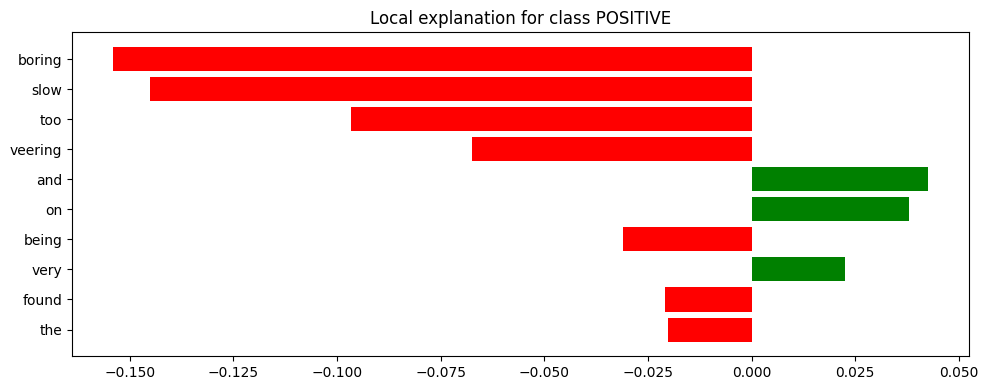

In [22]:

# 7.4  Visual explanation (matplotlib)

fig = exp_neg.as_pyplot_figure()
fig.set_size_inches(10, 4)
fig.tight_layout()


The LIME visualization for the negative review confirms that **"boring"** and **"slow"** are the dominant contributors to the negative classification.

**LIME strengths:** Model-agnostic, intuitive, produces human-readable explanations.

**LIME limitations:** Explanations are local (valid only near the specific input), sensitive to the number of perturbation samples, and assume word-level independence (removing "not" and "good" independently does not capture the phrase "not good").

---

## Recipe 8 — Explainability via Text Generation (Anchors)

**Anchors** find the **minimal set of words** (the "anchor") that guarantees the prediction stays the same regardless of what other words surround them:

$$P\big(f(\mathbf{z}) = f(\mathbf{x}) \;\big|\; A \subseteq \mathbf{z}\big) \geq \tau$$

where $f$ is the classifier, $\mathbf{x}$ is the original input, $\mathbf{z}$ are perturbed versions, and $\tau$ is a precision threshold (e.g., 0.95). The library can use either `UNK` tokens or BERT-generated replacements for perturbation.

In [23]:

# 8.1  Anchor explanation with UNK perturbation

import spacy
from anchor import anchor_text

nlp_spacy = spacy.load("en_core_web_sm")

def predict_label(texts):
    preds = sentiment_pipe(list(texts))
    return np.array([
        0 if label[0]["label"] == "NEGATIVE" else 1
        for label in preds
    ])

text = "The little mermaid is a good story."
pred = predict_label([text])[0]
print(f'Text: "{text}"')
print(f"Prediction: {'POSITIVE' if pred == 1 else 'NEGATIVE'}")
print()

# UNK-based anchors
explainer_unk = anchor_text.AnchorText(
    nlp_spacy, ["NEGATIVE", "POSITIVE"],
    use_unk_distribution=True)

exp_unk = explainer_unk.explain_instance(
    text, predict_label, threshold=0.95)

print(f"Anchor words: {' AND '.join(exp_unk.names())}")
print(f"Precision: {exp_unk.precision():.2f}")
print()

print("Examples maintaining POSITIVE prediction:")
same_pred = [x[0] for x in exp_unk.examples(only_same_prediction=True)]
for s in same_pred[:5]:
    print(f"  {s}")


Text: "The little mermaid is a good story."
Prediction: POSITIVE

Anchor words: good AND a AND is
Precision: 1.00

Examples maintaining POSITIVE prediction:
  The little UNK is a good story .
  The little UNK is a good UNK UNK
  The little UNK is a good UNK UNK
  UNK little UNK is a good UNK .
  UNK UNK UNK is a good story .


The anchor identifies **"good"** (and possibly "is" and "a") as the minimal set of words that guarantees a POSITIVE prediction. Even when "little mermaid" and "story" are replaced with UNK, the prediction holds.

In [24]:

# 8.2  Anchor explanation with BERT perturbation

explainer_bert = anchor_text.AnchorText(
    nlp_spacy, ["NEGATIVE", "POSITIVE"],
    use_unk_distribution=False)

exp_bert = explainer_bert.explain_instance(
    text, predict_label, threshold=0.95)

print(f"Anchor words (BERT perturbation): "
      f"{' AND '.join(exp_bert.names())}")
print(f"Precision: {exp_bert.precision():.2f}")
print()

print("POSITIVE examples (BERT-generated):")
same = [x[0] for x in exp_bert.examples(only_same_prediction=True)]
for s in same[:8]:
    print(f"  {s}")

print()
print("NEGATIVE examples (BERT-generated):")
diff = [x[0] for x in exp_bert.examples(only_different_prediction=True)]
for s in diff[:8]:
    print(f"  {s}")


Anchor words (BERT perturbation): good AND mermaid AND story
Precision: 0.96

POSITIVE examples (BERT-generated):
  wa ##lter mermaid = a good story |
  • { mermaid } | good story |
  sure little mermaid tells a good story .
  ^ Female mermaid : a good story .
  • ^ mermaid canyon | good story |
  a rich mermaid gives a good story .
  White little mermaid tells a good story .
  brave little mermaid : a good story …

NEGATIVE examples (BERT-generated):
  “ glorious mermaid ! Not good story .
  your wonderful mermaid ##s not good story .
  ah ##med mermaid takes little good story .
  I miss mermaid like a good story .
  Only sweet mermaid is a good story .
  neither nor mermaid deserve a good story .
  miss lady mermaid , thou good story .
  skip ##py mermaid is a good story .


With BERT-based perturbation, the generated alternatives are **natural sentences** rather than UNK-filled fragments. POSITIVE examples show that replacing "little mermaid" with other subjects keeps the prediction, confirming the classifier focuses on "good." NEGATIVE examples show cases where BERT's replacements introduce negative-sentiment words, flipping the prediction.

**LIME vs. Anchors:**

| Aspect | LIME | Anchors |
|--------|------|---------|
| **Output** | Per-word importance scores | Minimal sufficient word set |
| **Question answered** | "How much does each word matter?" | "What words are enough?" |
| **Interpretability** | Continuous weights | Binary (in/out of anchor) |
| **Speed** | Faster (fewer perturbations) | Slower (needs many samples) |
| **Best for** | Understanding relative importance | Finding decision rules |

---

## Summary and Key Takeaways

This chapter demonstrated that transformers can be applied to a wide range of NLU tasks beyond simple classification:

**Question Answering** spans a spectrum from extractive (copying spans) to abstractive (generating answers). The retriever-reader pattern scales QA to large document corpora by first narrowing the search space, then applying a reader model to the candidates.

**Summarization** benefits from purpose-built models: BART-CNN for extractive-leaning summaries, PEGASUS for concise abstractive summaries, and T5 as a flexible general-purpose option.

**Textual Entailment** is a foundational NLU capability that powers zero-shot classification, fact verification, and document consistency checking.

**Explainability** remains critical for trust and debugging. Both LIME (per-word importance) and Anchors (sufficient word sets) are model-agnostic and can be applied to any text classifier.

The common thread: modern NLU combines pre-trained transformer representations with task-specific architectures and inference strategies to solve complex language understanding problems.